In [1]:
#importing from google colab the drive class inorder to mount my drive which I  uploaded the dataset on and I will leave a copy
#of the dataset in the code folder but u will have to upload the dataset on your drive and change the directory for you to run the code
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# import the necessary packages we will discuss each one later in the code
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler
import keras
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report




In [11]:
steps_per_epoch=200
EPOCHS = 50
BS = 128
INIT_LR= 0.001

In [4]:
DIRECTORY = r"/content/drive/MyDrive/Alzheimer-dataset"

train_path = "/content/drive/MyDrive/Alzheimer-dataset/train"
val_path= "/content/drive/MyDrive/Alzheimer-dataset/valid"
test_path ="/content/drive/MyDrive/Alzheimer-dataset/test"

In [5]:
# construct the training image generator for data augmentation
train_aug = ImageDataGenerator(
  rescale=1/255,
	rotation_range=20,
	zoom_range=0.15,
	width_shift_range=0.2,
	height_shift_range=0.2,
	shear_range=0.15,
	horizontal_flip=True,
	fill_mode="nearest")

val_aug = ImageDataGenerator(
	rescale=1/255,
	rotation_range=20,
	zoom_range=0.15,
	width_shift_range=0.2,
	height_shift_range=0.2,
	shear_range=0.15,
	horizontal_flip=True,
	fill_mode="nearest")

test_aug = ImageDataGenerator(
  rescale=1/255,
	rotation_range=20,
	zoom_range=0.15,
	width_shift_range=0.2,
	height_shift_range=0.2,
	shear_range=0.15,
	horizontal_flip=True,
	fill_mode="nearest")

In [6]:
train_batch= train_aug.flow_from_directory(train_path,target_size= (224,224),batch_size=BS)
val_batch= val_aug.flow_from_directory(val_path,target_size= (224,224),batch_size=BS)
test_batch= test_aug.flow_from_directory(test_path,target_size= (224,224),batch_size=BS)

Found 6929 images belonging to 4 classes.
Found 95 images belonging to 4 classes.
Found 2876 images belonging to 4 classes.


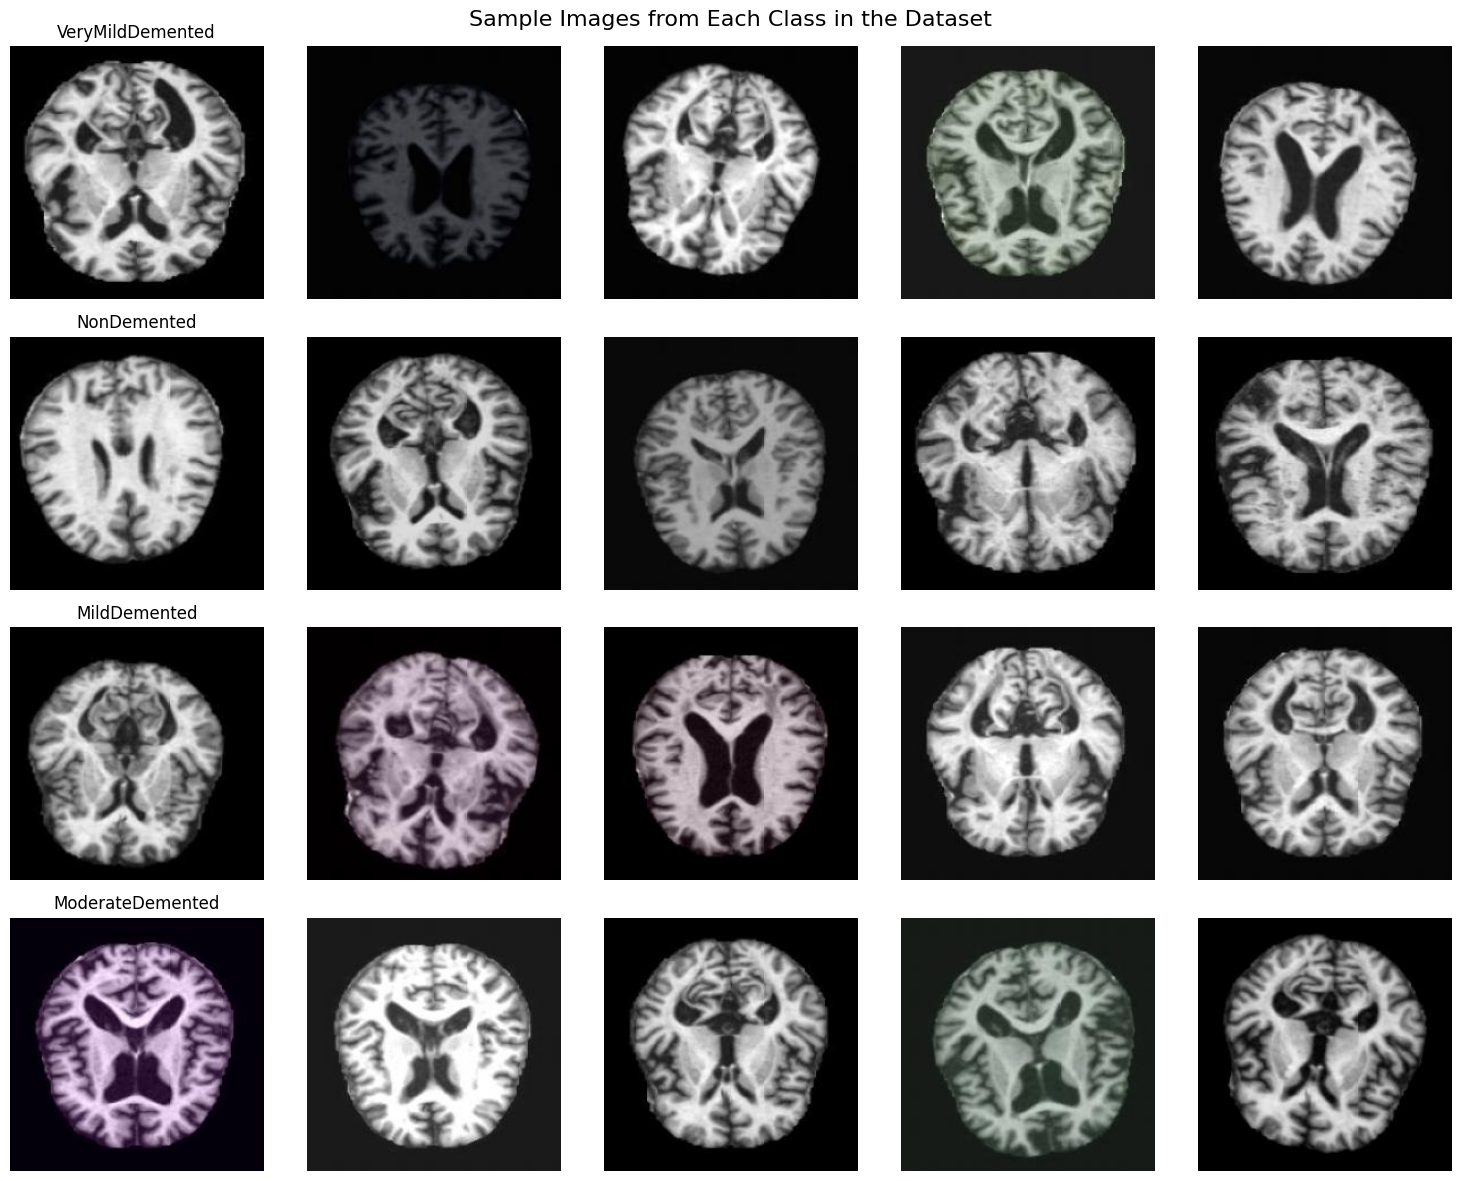

In [7]:
import os
import matplotlib.pyplot as plt
from PIL import Image

def plot_images_in_classes(train_path, num_images=5):
    """
    Plots a specified number of images for each class in subplots.

    Parameters:
    - train_path (str): Path to the training directory where each subdirectory is a class.
    - num_images (int): Number of images to display per class.
    """
    # Get list of class directories in the training path
    classes = os.listdir(train_path)

    # Set up the overall plot configuration
    fig, axs = plt.subplots(len(classes), num_images, figsize=(15, len(classes) * 3))
    fig.suptitle("Sample Images from Each Class in the Dataset", fontsize=16)

    for idx, class_name in enumerate(classes):
        # Get the path to the class folder
        class_folder = os.path.join(train_path, class_name)
        # Get list of image files in the class folder
        images = os.listdir(class_folder)[:num_images]

        for i, img_name in enumerate(images):
            img_path = os.path.join(class_folder, img_name)
            # Open and display the image
            img = Image.open(img_path)
            ax = axs[idx, i] if len(classes) > 1 else axs[i]  # Adjust for single class case
            ax.imshow(img)
            ax.axis("off")
            # Set the title to the class name
            if i == 0:
                ax.set_title(class_name)

    plt.tight_layout()
    plt.subplots_adjust(top=0.95)
    plt.show()



plot_images_in_classes(train_path, num_images=5)

In [8]:
model = keras.models.Sequential([
    keras.layers.Conv2D(filters=128, kernel_size=(8, 8), strides=(3, 3), activation='relu', input_shape=(224, 224, 3)),
    keras.layers.BatchNormalization(),

    keras.layers.Conv2D(filters=256, kernel_size=(5, 5), strides=(1, 1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3, 3)),

    keras.layers.Conv2D(filters=256, kernel_size=(3, 3), strides=(1, 1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=256, kernel_size=(1, 1), strides=(1, 1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=256, kernel_size=(1, 1), strides=(1, 1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),

    keras.layers.Conv2D(filters=512, kernel_size=(3, 3), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(2, 2)),

    keras.layers.Conv2D(filters=512, kernel_size=(3, 3), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),

    keras.layers.Conv2D(filters=512, kernel_size=(3, 3), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),

    keras.layers.MaxPool2D(pool_size=(2, 2)),

    keras.layers.Conv2D(filters=512, kernel_size=(3, 3), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),

    keras.layers.MaxPool2D(pool_size=(2, 2)),

    keras.layers.Flatten(),
    keras.layers.Dense(1024, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(1024, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(4, activation='softmax')
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 73, 73, 128)       24704     
                                                                 
 batch_normalization (Batch  (None, 73, 73, 128)       512       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 73, 73, 256)       819456    
                                                                 
 batch_normalization_1 (Bat  (None, 73, 73, 256)       1024      
 chNormalization)                                                
                                                                 
 max_pooling2d (MaxPooling2  (None, 24, 24, 256)       0         
 D)                                                              
                                                        

In [9]:



LR_SCHEDULE = [
    # (epoch to start, learning rate) tuples
    (3, 0.001),
    (9, 0.0005),
    (12, 0.0001),
]


def lr_scheduler(epoch, lr):
    """Helper function to retrieve the scheduled learning rate based on epoch."""
    if epoch < LR_SCHEDULE[0][0] or epoch > LR_SCHEDULE[-1][0]:
        return lr
    for i in range(len(LR_SCHEDULE)):
        if epoch == LR_SCHEDULE[i][0]:
            return LR_SCHEDULE[i][1]
    return lr

lr_schedule = keras.callbacks.LearningRateScheduler(lr_scheduler)

model_checkpoint = ModelCheckpoint(
    filepath=DIRECTORY+'.weights.h5',
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

early_stopping = EarlyStopping(monitor='loss', patience=7, verbose=1, mode='min')

In [12]:
# compile our model
from tensorflow.keras.optimizers import Adam, SGD
optimizer = Adam(
    learning_rate=0.0001,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-07,
    ema_momentum=0.99,

)
optimizer2= SGD(learning_rate=INIT_LR)

model.compile(loss="categorical_crossentropy", optimizer=optimizer2,
	metrics=["accuracy"])

In [ ]:

H = model.fit(
	train_batch,
	steps_per_epoch=steps_per_epoch,
	validation_data=val_batch,
	epochs=EPOCHS,
	verbose=1,
	callbacks=[model_checkpoint,early_stopping])



In [ ]:
import numpy as np

def plot_test_batch_predictions(test_batch, model, num_images=5):
    """
    Displays a batch of test images with the model's predicted and actual labels.

    Parameters:
    - test_batch: An ImageDataGenerator batch iterator (e.g., `test_batch`).
    - model: Trained model used for predictions.
    - num_images (int): Number of images to display from the batch.
    """
    # Get one batch of images and labels from the test generator
    images, labels = next(test_batch)

    # Convert one-hot encoded labels to class indices
    true_classes = np.argmax(labels, axis=1)
    class_names = list(test_batch.class_indices.keys())

    # Make predictions on the batch
    predictions = model.predict(images)
    predicted_classes = np.argmax(predictions, axis=1)

    # Set up the plot
    fig, axs = plt.subplots(1, num_images, figsize=(15, 5))
    fig.suptitle("Model Predictions vs. Actual Labels", fontsize=16)

    for i in range(num_images):
        # Display image
        ax = axs[i]
        ax.imshow(images[i])
        ax.axis("off")

        # Get true and predicted labels
        true_label = class_names[true_classes[i]]
        predicted_label = class_names[predicted_classes[i]]

        # Set title with both actual and predicted class
        color = "green" if predicted_label == true_label else "red"
        ax.set_title(f"True: {true_label}\nPred: {predicted_label}", color=color)

    plt.tight_layout()
    plt.show()


plot_test_batch_predictions(test_batch, model, num_images=5)


In [ ]:
#saving the trained model inorder to use it in the detection app
model.save("Alzheimer.model.h5")

In [ ]:
# plot the training loss and accuracy
N = len(H.history['loss'])
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("plot.png")